# 基于 p-Stable 分布的 LSH——E2LSH

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn import datasets
from scipy.stats import norm
from scipy.stats import cauchy
import scipy.stats as stats
import math
from sklearn import datasets
from sklearn.preprocessing import Normalizer
from hashlib import md5
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mbyte = 1048576
norm_l1 = Normalizer(norm='l1')
norm_l2 = Normalizer(norm='l2')

In [2]:
rand = np.random.RandomState(1)

## p-stable 分布

### stable 分布

> 给定 $X_1, X_2, ..., X_n$ 为 $X$ 的独立随机变量  
> 我们有一个符合 $\alpha = p$ 的稳定分布，与一个向量 $a = (a_1, a_2, ..., a_n)$  
> 则
$$
S = a_1X_1 + a_2X_2 + ... + a_nX_n
$$
与 $||a||_p X$ 同分布

- 当 $\alpha = 2$ 时，为高斯分布 

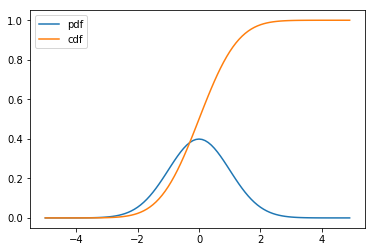

In [3]:
# 高斯分布绘制
X = np.arange(-5, 5, 0.1)
y1 = stats.norm.pdf(X, 0, 1)
y2 = stats.norm.cdf(X, 0, 1)
plt.plot(X, y1, label='pdf')
plt.plot(X, y2, label='cdf')
plt.legend()
plt.show()

绘制高斯分布

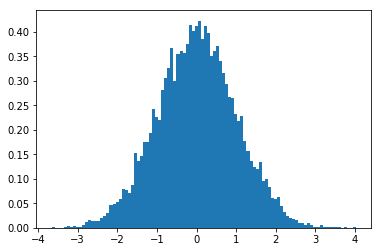

In [4]:
x = rand.normal(0, 1, 10000)
plt.hist(x, bins=100, density=True)
plt.show()

In [5]:
v1, v2 = np.array([[1, 1], [2, 2]])
X = rand.normal(0, 1, 10000)
a = rand.normal(0, 1, (10000, 2))

$$
(a\cdot v_1 - a\cdot v_2) ～||v_1-v_2||_pX
$$


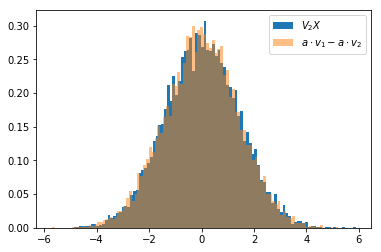

In [6]:
V_norm = np.linalg.norm(v1 - v2)
plt.hist(V_norm * X, bins=100, density=True, label='$V_2X$')
plt.hist(a.dot(v1) - a.dot(v2), bins=100, density=True, alpha=0.5, label='$a\cdot v_1 - a\cdot v_2$')
plt.legend()
plt.show()

### 通过稳定分布估计 $l_p$ 范式

$$
med(X) = median(X)
$$

对于 $\forall s $
$$
med(s\cdot |X|) = s\cdot med(|X|)
$$

所以我们有
$$
\begin{align}
med(|S|) &= med(||a||_p\cdot|X|) \\
&= ||a||_p\cdot med(|X|) \\
\end{align}\\
$$
得出
$$
||a||_p = \frac{med(|S|)}{med(|X|)}
$$

## 参数

$$
k = log_{\frac{1}{p_2}}n \\
\rho = \frac{\text{log}(\frac{1}{p_1})}{\text{log}(\frac{1}{p_2})}
$$

In [7]:
def compute_rho(p1, p2):
    return np.log(1/p1) / np.log(1/p2)

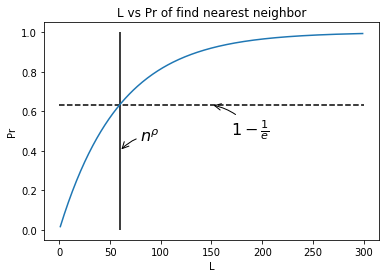

In [8]:
p1 = 0.7
p2 = 0.3
rho = compute_rho(p1, p2)
L = np.array(np.arange(1, 300, 1))
n = 1e6
plt.plot(L, 1 - (1 - 1. / n ** rho) ** L)
plt.vlines(x=n**rho, ymax=1, ymin=0)
plt.annotate(r"$n^\rho$", xy=(n ** rho, 0.4), xytext=(20, 10), fontsize=16,
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))


plt.hlines(y=1 - 1 / np.e, xmin=0, xmax=300, linestyles='--')

plt.annotate(r"$1 - \frac{1}{e}$", xy=(150, 1 - 1 / np.e), xytext=(20, -30), fontsize=16,
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))

plt.xlabel('L')
plt.ylabel('Pr')
plt.title('L vs Pr of find nearest neighbor')
plt.show()

在 rho 固定的情况下，L值增大， 相邻点落入同一个桶的概率会增大，但逐渐趋于稳定。  
在本文中，我们取 $L = n^\rho$，此时，

In [9]:
def logab(a, b):
    return np.log(b) / np.log(a)

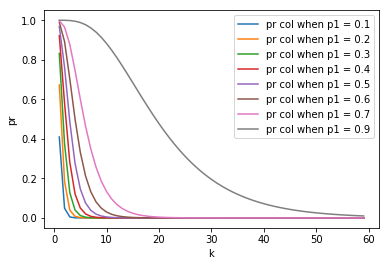

In [10]:
# 固定L、n，相似点碰撞概率与k、p1的关系
p1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
n = 100000
k = np.arange(1, 60, 1)
L = 5
for p in p1:
    pr_col =  1 - (1 - p ** k) ** L
    plt.plot(k, pr_col, label='pr col when p1 = {}'.format(p))
plt.legend()
plt.xlabel('k')
plt.ylabel('pr')
plt.show()

随着 k 的增大，距离 $> cR$ 的点碰撞的概率下降  
同时 距离 $< R$ 的点碰撞的概率也下降，但速度较缓

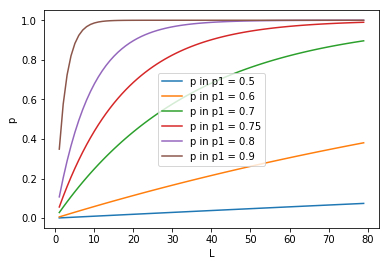

In [11]:
p1 = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
k = 10
L = np.arange(1, 80, 1)
for p in p1:
    p_col = 1 - (1 - p ** k)**L
    plt.plot(L, p_col, label='p in p1 = {}'.format(p))
plt.legend()
plt.xlabel('L')
plt.ylabel('p')
plt.show()

L增大会增大相邻点落入同一桶的概率

由上图可得随着概率 $p_2$ 的增大（逐步靠近1），$k$ 值增大。

计算 hash 的时间相应也增大

$$
L = n^{\rho}
$$

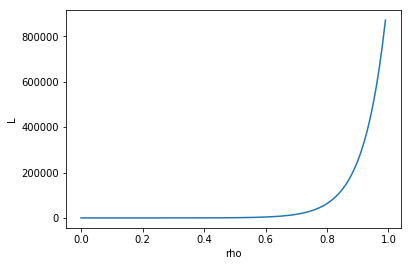

In [12]:
n = 1000000
rho = np.arange(0, 1, 0.01)
L = n ** rho
plt.plot(rho, L)
plt.xlabel('rho')
plt.ylabel('L')
plt.show()

$$
\rho = \frac{ln\frac{1}{p_1}}{ln\frac{1}{p_2}}
$$

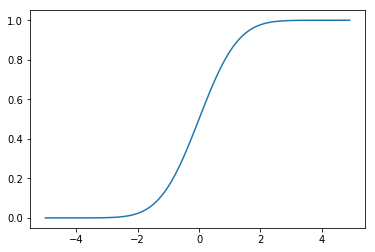

In [13]:
# 累积分布
p = np.arange(-5, 5, 0.1)
p_cdf = norm.cdf(p)
plt.plot(p, p_cdf)
plt.show()

In [14]:
def compute_p(w, r):
    """
    Args:
        w: 段长
        r: r1, r2, 距离
    """
    a = 2 * norm.cdf(-w/r)
    b = 2 / (np.sqrt(2 * np.pi) * w / r)
    d = np.e ** (-((w**2) / (2 * (r ** 2))))
    # print('a:{}, b:{}, c:{}'.format(a, b, d))
    return 1 - a - b * (1 - d)

In [15]:
def compute_rho(p1, p2):
    return (np.log(1/p1) / np.log(1/p2))

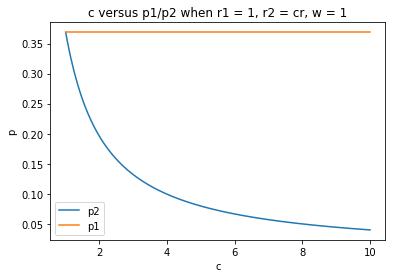

In [16]:
C = np.arange(1, 10.05, 0.05)
# 假设 r1 = 1, r2 = cr
r1 = 1
p1 = np.array([compute_p(1, r1) for c in C])
p2 = np.array([compute_p(1, c * r1) for c in C])
plt.plot(C, p2, label='p2')
plt.plot(C, p1, label='p1')
plt.xlabel('c')
plt.legend()
plt.ylabel('p')
plt.title('c versus p1/p2 when r1 = 1, r2 = cr, w = 1')
plt.show()

$p_1$ 稳定在 $\frac{1}{e}$  
$p_2$ 随着 近似参数 $c$ 的增大逐渐减小（因为近似范围越大且段长 $r$ 固定的情况下，落在外面的点也就越小）

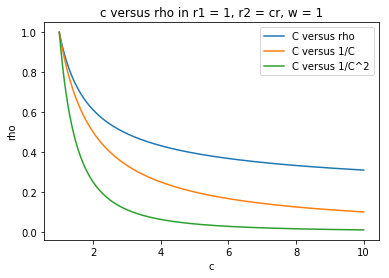

In [17]:
C = np.arange(1, 10.05, 0.05)
w = 1
r1 = 1
p1 = compute_p(w, r1)
p2 = [compute_p(w, c * r1) for c in C]
rho = [compute_rho(p1, p2_) for p2_ in p2]
plt.plot(C, rho, label='C versus rho')
plt.plot(C, 1 / C, label='C versus 1/C')
plt.plot(C, 1/(C**2), label='C versus 1/C^2')
plt.legend()
plt.xlabel('c')
plt.ylabel('rho')
plt.title('c versus rho in r1 = 1, r2 = cr, w = 1')
plt.show()

随着近似参数 $c$ 的值逐渐增大，$p_2$ 减小，导致 $\rho$ 也减小

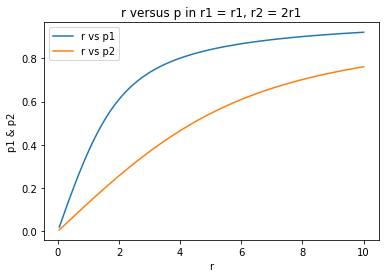

In [18]:
R = np.arange(0.05, 10.05, 0.05)
r1 = 1
c = 3
p1 = np.array([compute_p(w, r1) for w in R])
p2 = np.array([compute_p(w, c * r1) for w in R])
plt.plot(R, p1, label='r vs p1')
plt.plot(R, p2, label='r vs p2')
plt.xlabel('r')
plt.ylabel('p1 & p2')
plt.legend()
plt.title('r versus p in r1 = r1, r2 = 2r1')
plt.show()

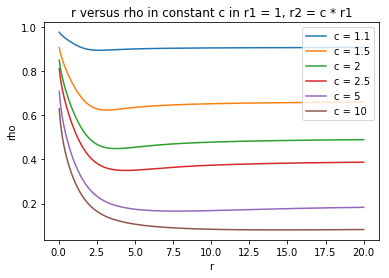

In [19]:
W = np.arange(0.05, 20.05, 0.05)
C = [1.1, 1.5, 2, 2.5, 5, 10]
r1 = 1
for c in C:
    p1 = np.array([compute_p(w, r1) for w in W])
    p2 = np.array([compute_p(w, c * r1) for w in W])
    rho = compute_rho(p1, p2)
    plt.plot(W, rho, label='c = {}'.format(c))
plt.legend()
plt.xlabel('r')
plt.ylabel('rho')
plt.title('r versus rho in constant c in r1 = 1, r2 = c * r1')
plt.show()

$r_2$ 越大，$\rho$ 下降越快、越小

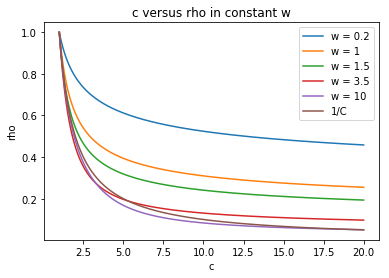

In [20]:
C = np.arange(1, 20.05, 0.05)
W = [0.2, 1, 1.5, 3.5, 10]
r1 = 1
for w in W:
    p1 = np.array([compute_p(w, r1) for c in C])
    p2 = np.array([compute_p(w, c * r1) for c in C])
    rho = compute_rho(p1, p2)
    plt.plot(C, rho, label='w = {}'.format(w))
plt.plot(C, 1/C, label='1/C')
plt.legend()
plt.xlabel('c')
plt.ylabel('rho')
plt.title('c versus rho in constant w')
plt.show()

$$
p = 1 - \delta
$$
例如我们想要保证至少落在一个桶的准确率为 0.9, 即 $\delta = 0.1$  

## 寻参的步骤及一个例子

### 1. 确定 $r_1$
> 首先我们需要确定 $r_1$, 并保证至少有一个近似点落入 $B(q, r_1)$

### 2. 在保证错误率 $\delta$ 的情况下，确定 k 值（确定最小运行时间） 

$$
\begin{align}
T &= T_g + T_c \\
&= O(dkL) + O(dL\cdot \sum_{p\in P} p^k(||q - p||))
\end{align}
$$
其中 $T_g$ 为计算 哈希桶 的时间  
$T_c$ 为与每个碰撞的点进行距离比较的时间  

显然，随着 $k$ 的增大， $T_g$ 增大， $T_c$ 减小  

我们的目标是 **寻找最优值 $k$, 最小化 $T$**  

由于与 $||q - p||$ 有关，所以不同的查询点 $q$ 可能有不同的最优 $k$  
所以我们需要取对于所有点的最优的平均查询时间

我们求解 (r1, c)-NN 问题  
假设 $r_1 = 0.1$ 可以保证至少有一个近似点落入 $B(q, r_1)$  
$c = 3$  
则通过 $w\ vs\ p1\ vs\ p2$ 的图像我们可以得到理想的 $w$ (段长) 值

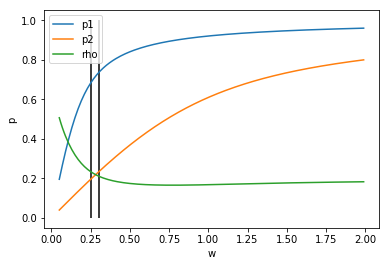

In [21]:
n = 1000000
r1 = 0.1  # r1 要保证至少有一个近似点落入 B(q, r1)
W = np.arange(r1 / 2, 2, 0.01)
c = 5
p1 = [compute_p(w, r1) for w in W]
p2 = [compute_p(w, c * r1) for w in W]
rho1 = [compute_rho(p1[i], p2[i]) for i in range(len(W))]
plt.plot(W, p1, label='p1')
plt.plot(W, p2, label='p2')
plt.plot(W, rho1, label='rho')
plt.vlines(x=0.25, ymin=0, ymax=1)
plt.vlines(x=0.3, ymin=0, ymax=1)
plt.xlabel('w')
plt.ylabel('p')
plt.legend()
plt.show()

通过上图我们可得 $w = 0.3$ 可取近似最优值
此时可求解对应的 $p_1$, $p_2$

假设我们想要保证 $delta = 0.1$ 的错误率，则
$$
1 - (1 - p_1^k)^L \ge 1 - \delta \\
L = \lceil \frac{log\frac{1}{\delta}}{-log(1 - p_1^k)}\rceil
$$

In [22]:
def get_L(delta, p1, k):
    return math.ceil(math.log(1/delta) / -math.log(1 - p1 ** k))

In [23]:
w = 0.5
p1 = compute_p(w, r1)
p2 = compute_p(w, c * r1)
rho_result = compute_rho(p1, p2)
print('p1  = {:.4f}\np2  = {:.4f}\nrho = {:.4f}'.format(p1, p2, rho_result))

p1  = 0.8404
p2  = 0.3687
rho = 0.1743


由
$$
k = log_{\frac{1}{p_2}}n \\
L = n^\rho
$$
可得

In [24]:
k = math.ceil(logab(1/p2, n))
L = math.ceil(n ** rho_result) # 此时的 L 保证错误率 为 1/e
delta = 0.2 # 错误率
L = get_L(delta, p1, k)  # 此时的 L 保证错误率为 0.2
print('k = {}, L = {}'.format(k, L))

k = 14, L = 18


## 实验

### 工具函数

In [25]:
from hashlib import md5

def generate_md5(H):
    hmd5 = md5()
    hmd5.update(str(H).encode(encoding='utf-8'))
    return hmd5.hexdigest()

### Metrics

In [26]:
def metrics_pr_find_nearest(P, query_func, args, test, exact_nearest):
    test_n = test.shape[0]
    not_found = 0
    correct = 0

    for i in range(test_n):
        result = query_func(args, test[i])
        if len(result) != 0:
            if exact_nearest[i] in result:
                correct += 1
        else:
            correct += 1

    return correct / test_n

### 参数类

In [27]:
class E2LSH_param(object):
    """
    Desc:
        E2LSH param class.
    
    Construct step:
        1. set_r1: 
            set r1 value automatic.
            
        2. draw_W: 
            According to the given value c draw the p1-p2-rho-w figure.
            
        3. set_wkL:
            Give failure probability delta and caculate the value k, L
            
        4. generate_auxiliary_vector:
            Generate G = (g1, g2, ..., gL) -> gi = (h1, h2, ..., hk)
    
    Params:
        class contains follow params.
        self.P
        self.n_
        self.d_
        self.w_
        self.k_
        self.L_
        self.G_
    """

    def __init__(self, P, distance_function='euclidean'):
        """
        Args:
            P: 数据集
            norm: 正则项(l1, l2)
        """
        self.P = P
        self.n_ = P.shape[0]
        self.d_ = P.shape[1]

        self.distance_function_=distance_function

    def _logab(self, a, b):
        """
        Desc:
            求解 log_a b
        """
        return np.log(b) / np.log(a)

    def _Pr(self, w, c):
        """
        Args:
            w: 段长
            c: r1, r2, 距离
        """
        if self.distance_function_ == 'euclidean':
            a = 2 * norm.cdf(-w/c)
            b = 2 / (np.sqrt(2 * np.pi) * w / c)
            d = np.e ** (-((w**2) / (2 * (c ** 2))))    
            return 1 - a - b * (1 - d)

        elif self.distance_function_ == 'hamming':
            a = w/c
            b = 2 * (np.arctan(a)) / np.pi
            d = 1 / (np.pi * a)
            e = np.log(1 + (a**2))
            return b - d * e
    
    def _rho(self, p1, p2):
        return (np.log(1/p1) / np.log(1/p2))
    
    # 1. set r1
    def set_r1(self, r1=None):
        """
        Desc:
            获取数据集 r1
        """
        P = self.P
        d = P.shape[1]
        print('Estimate r1')
        print('P: {}'.format(P.shape))
        if r1 is not None:
            self.r1_ = r1
            print('set r1 = {}'.format(r1))
            return

    #     n = P.shape[0] * 0.03
        n = 20
        nn = int(np.log(P.shape[0]))
        print('sample {} points, calculate near {} neighbors.'.format(n, nn))
        idx = np.random.choice(P.shape[0], size=n, replace=False)
        qs = P[idx]
        r1_avg = []
        for q in qs:
            if self.distance_function_ == 'euclidean':
                dist_arr = np.array([distance.euclidean(q, p) for p in P])
            elif self.distance_function_ == 'hamming':
                dist_arr = np.array([distance.hamming(q, p) for p in P])
            dist_sort = np.sort(dist_arr)
            avg = np.sort(dist_arr)[1:nn+1].mean()
            r1_avg.append(avg)
        if self.distance_function_ == 'euclidean':
            r1 = np.array(r1_avg).mean()
        elif self.distance_function_ == 'hamming':
            r1 = math.floor(np.array(r1_avg).mean())
        
        self.r1_ = r1
        print('estimate r1 = {}'.format(self.r1_))
        return r1

    def draw_W(self, c=2):
        """
        Desc:
            绘制图像，观察最优 w 值
        Args:
            c: 近似因子
        """
        r1 = self.r1_
        if self.distance_function_ == 'euclidean':
            W = np.arange(r1 / 2, r1 * 10, r1 / 2)
        elif self.distance_function_ == 'hamming':
            W = np.arange(r1 / 2, r1 * 10, 1)
            
        self.c_ = c
        self.r2_ = c * r1
    
        p1 = [self._Pr(w, r1) for w in W]
        p2 = [self._Pr(w, c * r1) for w in W]
        rho = [self._rho(p1[i], p2[i]) for i in range(len(W))]

        plt.plot(W, p1, label='p1')
        plt.plot(W, p2, label='p2')
        plt.plot(W, rho, label='rho')
        plt.hlines(y=1/c, xmin=0, xmax=r1 * 10, label='1/c')
        plt.xlabel('w')
        plt.ylabel('p')
        plt.legend()
        plt.show()
    
    def set_wkL(self, w, delta=np.e):
        """
        Desc:
            设置参数 w, k, L
        Args:
            w: 段宽
            delta: 错误率 (0, 1)
        """
        self.delta_ = delta
        self.w_ = w

        p1 = self._Pr(w, self.r1_)
        p2 = self._Pr(w, self.c_ * self.r1_)
        rho = self._rho(p1, p2)
        self.p1_ = p1
        self.p2_ = p2
        self.rho_ = rho
        
        k = math.ceil(self._logab(1 / p2, self.n_))
        self.k_ = k

        # delta 为 e 时
        if self.delta_ == np.e:
            L = math.ceil(self.n_ ** rho)

        else:
            L = math.ceil(math.log( 1 / self.delta_) / -math.log(1 - p1 ** k))
        self.L_ = L
    
        print('set w = {}'.format(w))
        print('p1 = {:.4f}, p2 = {:.4f}, rho = {:.4f}'.format(p1, p2, rho))
        print('k = {}, L = {}'.format(k, L))
    
    def generate_auxiliary_vector(self):
        """
        Desc:
            生成 G
        """

        d = self.d_
        w = self.w_
        k = self.k_
        L = self.L_
        print('Generate auxiliary vector: G.')
        print('For each g in G (total {}), have {} hash functions.'.format(L, k))

        # 生成 G
        G = []
        
        for i in range(L):
            g = []
            for i in range(k):
                if self.distance_function_ == 'euclidean':
                    a = np.random.normal(0, 1, d)
                    b = np.random.uniform(0, w)
                else:
                    a = np.random.standard_cauchy(d)
                    b = np.random.uniform(0, w)
                g.append((a, b))
            G.append(g)
        self.G_ = G

    def print_params(self):
        print('({}, {}, {:.4f}, {:.4f})-sensitive'.format(self.r1_, self.r1_ * self.c_, self.p1_, self.p2_))
        print('rho = {:.4f}'.format(self.rho_))
        print('k = {}, L = {}'.format(self.k_, self.L_))

### 处理函数

In [28]:
def E2LSH_process(e2lsh_param):
    P = e2lsh_param.P
    G = e2lsh_param.G_
    w = e2lsh_param.w_
    
    hash_tables = []
    for i, g in enumerate(G):
        hash_tables.append(dict())
        for j, p in enumerate(P):
            g_val = np.array([math.ceil((p.dot(h[0]) + h[1]) / w) for h in g])
            bi = generate_md5(g_val)
            if bi not in hash_tables[i]:
                hash_tables[i][bi] = [j]
            else:
                hash_tables[i][bi].append(j)

    return hash_tables

### 查询函数

In [29]:
def E2LSH_query(args, q, distance_function='euclidean'):
    """
    Desc:
        E2LSH query function
    Args:
        P: 点集
        args:
            [0]: E2LSH_param
            [1]: buckets
        q: 查询点
    """
    G = args[0].G_
    w = args[0].w_
    buckets = args[1]

    result = []
    
    for i, g in enumerate(G):
        g_val = np.array([math.ceil((q.dot(h[0]) + h[1]) / w) for h in g])
        bi = generate_md5(g_val)
        if bi in buckets[i]:
            result.append(buckets[i][bi])

    result = np.unique(np.concatenate(np.array(result)))

    return result

### 数据

In [30]:
# 最近邻数据
%store -r Datasets

In [31]:
Datasets.keys()

dict_keys(['SIFT-10K'])

In [32]:
data = Datasets['SIFT-10K']

train = data['train']
test = data['test']

### 测试

#### $\delta = 1/e$

In [33]:
param = E2LSH_param(P=train)

In [34]:
%%time
param.set_r1()

Estimate r1
P: (10000, 128)
sample 20 points, calculate near 9 neighbors.
estimate r1 = 247.84407957775548
CPU times: user 3.09 s, sys: 46.8 ms, total: 3.14 s
Wall time: 3.09 s


247.84407957775548

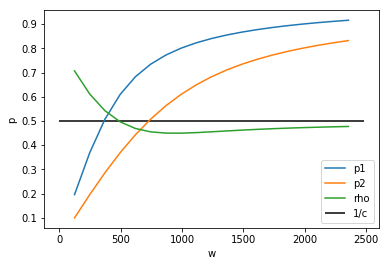

CPU times: user 145 ms, sys: 3.25 ms, total: 148 ms
Wall time: 147 ms


In [35]:
%%time
param.draw_W()

In [36]:
%%time
param.set_wkL(600)

set w = 600
p1 = 0.6725, p2 = 0.4316, rho = 0.4721
k = 11, L = 78
CPU times: user 719 µs, sys: 24 µs, total: 743 µs
Wall time: 701 µs


In [37]:
%%time
param.generate_auxiliary_vector()

Generate auxiliary vector: G.
For each g in G (total 78), have 11 hash functions.
CPU times: user 13.2 ms, sys: 90 µs, total: 13.3 ms
Wall time: 14.4 ms


In [38]:
%%time
hash_tables = E2LSH_process(param)

CPU times: user 1min 24s, sys: 291 ms, total: 1min 24s
Wall time: 1min 24s


In [39]:
%%time
metrics_pr_find_nearest(P=train, args=[param, hash_tables], 
                        query_func=E2LSH_query, test=test, 
                        exact_nearest=data['nearest_neighbor'])

CPU times: user 775 ms, sys: 3.28 ms, total: 778 ms
Wall time: 777 ms


0.81

#### $\delta = 0.1$

In [40]:
param = E2LSH_param(P=train)

In [41]:
%%time
param.set_r1()

Estimate r1
P: (10000, 128)
sample 20 points, calculate near 9 neighbors.
estimate r1 = 264.5644989433348
CPU times: user 2.64 s, sys: 3.2 ms, total: 2.64 s
Wall time: 2.65 s


264.5644989433348

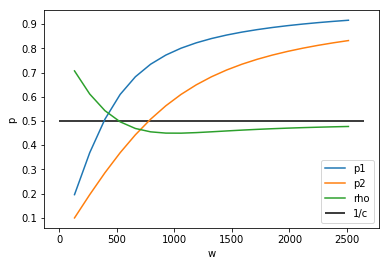

CPU times: user 248 ms, sys: 6.65 ms, total: 254 ms
Wall time: 253 ms


In [42]:
%%time
param.draw_W()

In [43]:
%%time
param.set_wkL(600, delta=0.1)

set w = 600
p1 = 0.6517, p2 = 0.4095, rho = 0.4795
k = 11, L = 255
CPU times: user 1.19 ms, sys: 0 ns, total: 1.19 ms
Wall time: 911 µs


In [44]:
%%time
param.generate_auxiliary_vector()

Generate auxiliary vector: G.
For each g in G (total 255), have 11 hash functions.
CPU times: user 33.4 ms, sys: 3.18 ms, total: 36.6 ms
Wall time: 36.2 ms


In [45]:
%%time
hash_tables = E2LSH_process(param)

CPU times: user 4min 2s, sys: 675 ms, total: 4min 3s
Wall time: 4min 4s


In [46]:
%%time
metrics_pr_find_nearest(P=train, args=[param, hash_tables], 
                        query_func=E2LSH_query, test=test, 
                        exact_nearest=data['nearest_neighbor'])

CPU times: user 2.49 s, sys: 3.29 ms, total: 2.5 s
Wall time: 2.5 s


0.94